In [1]:
import torch
import numpy as np
import copy
import pickle
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans

In [17]:
seq_dict = {'N':4, 'A':0, 'G':1, 'T':2, 'C':3}

seq_data = np.genfromtxt('seq_data.csv', delimiter=',', dtype=None)
seq_labels = np.array([x[0] for x in seq_data]).reshape(-1, 1)
sequences = [x[1].decode('utf-8') for x in seq_data]
sequences = np.array([[seq_dict[c] for c in x] for x in sequences])
print(seq_labels.shape)
print(sequences.shape)

C:\Users\seanq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until


(17447, 1)
(17447, 10000)


In [25]:
print(np.min(seq_labels))
print(np.max(seq_labels))
print(seq_labels[:5])

3
259752
[[  3]
 [  5]
 [419]
 [457]
 [460]]


In [20]:
train_data = np.load('train.npz')['E065']
print(train_data.shape)

(16000, 100, 7)


In [26]:
train_data[:5,0,0]
train_data[0, 0, :]

array([ 3.       ,  0.       ,  0.6931472,  0.       ,  0.       ,
        0.       , -2.9263823], dtype=float32)

In [27]:
gene_ids = train_data[:, 0, 0]

In [30]:
print(gene_ids.shape)
print(seq_labels.shape)
nonz = np.nonzero(gene_ids == seq_labels)
print(len(nonz))
print(nonz[0].shape)

(16000,)
(17447, 1)
2
(16000,)


In [34]:
print(nonz[0][:5])
print(gene_ids[:5])
print(seq_labels[nonz[0][:5], 0])
print(sequences[nonz[0]].shape)

[0 1 3 5 6]
[  3.   5. 457. 938. 971.]
[  3   5 457 938 971]
(16000, 10000)


In [2]:
k = 3
smoother = torch.nn.Conv1d(5, 5, k, padding=((k - 1)//2))
for i in range(5):
    smoother.weight[i] = torch.zeros_like(smoother.weight[0])
    smoother.weight[i][i] = 1 / k
    
smoother.bias[:] = 0

In [3]:
ins = torch.load('train_in.pt')
inputs = copy.deepcopy(ins)
inputs[inputs < 1.5] = 0
with torch.no_grad():
    print(torch.min(inputs))
    for i in range(4):
        inputs = smoother(inputs)
print(torch.mean(inputs, dim=(0, 2)))
print(inputs.size())
#inputs = (inputs - torch.mean(inputs, dim=0).view(1, 5, 100))
#inputs = (inputs - torch.mean(inputs, dim=2).view(-1, 5, 1))
#inputs = (inputs - torch.mean(inputs, dim=1).view(-1, 1, 100))
#print(torch.mean(inputs, dim=(0, 2)))
#inputs = inputs / torch.std(inputs, dim=(0,2)).view(1, -1, 1)
#print(torch.mean(inputs, dim=(0, 2)))
outputs = torch.load('train_out.pt')
np_ins = inputs.numpy()
np_outs = outputs.numpy()

tensor(0.)
tensor([0.2717, 0.2659, 0.5359, 1.1439, 0.0992])
torch.Size([720000, 5, 100])


In [31]:
# Thought experiment on how to add noise the inputs
'''
print(ins[:2,:2,:2])
ins = torch.exp(ins)
print(ins[:2,:2,:2])
ins = ins + torch.round(torch.randn(ins.shape))
print(ins[:2,:2,:2])
ins[ins < 1] = 1
print(ins[:2,:2,:2])
ins = torch.log(ins)
print(ins[:2,:2,:2])
'''

tensor([[[0.0000, 0.0000],
         [0.6931, 0.6931]],

        [[0.0000, 0.0000],
         [0.6931, 0.0000]]])
tensor([[[1., 1.],
         [2., 2.]],

        [[1., 1.],
         [2., 1.]]])
tensor([[[ 2., -2.],
         [ 3.,  3.]],

        [[ 0.,  0.],
         [ 3.,  2.]]])
tensor([[[2., 1.],
         [3., 3.]],

        [[1., 1.],
         [3., 2.]]])
tensor([[[0.6931, 0.0000],
         [1.0986, 1.0986]],

        [[0.0000, 0.0000],
         [1.0986, 0.6931]]])


In [4]:
# BASIC STATS #

Output Mean: -0.283
Output Variance: 3.553


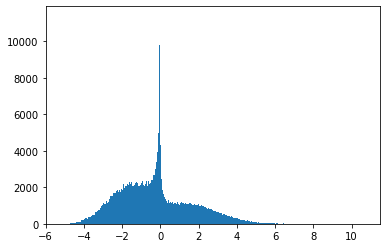

In [5]:
# Outputs
print('Output Mean: %.3f' % torch.mean(outputs))
print('Output Variance: %.3f' % torch.std(outputs)**2)
outputs_histogram = plt.hist(np_outs, 1000)

Input Mean: 0.466
Input Variance: 0.808


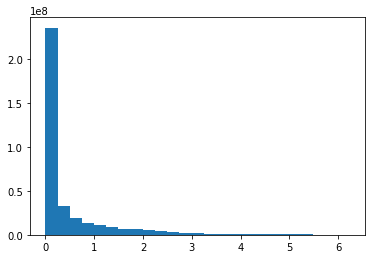

In [6]:
# Inputs

# Overall
print('Input Mean: %.3f' % torch.mean(inputs))
print('Input Variance: %.3f' % torch.std(inputs)**2)
inputs_histogram = plt.hist(np_ins.reshape(-1), 25)

Histone 1 Input Mean: 0.272
Histone 1 Input Variance: 0.357
Histone 2 Input Mean: 0.266
Histone 2 Input Variance: 0.296
Histone 3 Input Mean: 0.538
Histone 3 Input Variance: 0.576
Histone 4 Input Mean: 1.151
Histone 4 Input Variance: 2.043
Histone 5 Input Mean: 0.099
Histone 5 Input Variance: 0.078


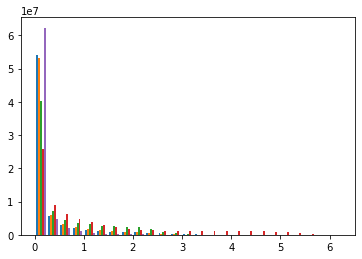

In [7]:
# Per Histone
for i_histone in range(5):
    print('Histone %d Input Mean: %.3f' % (i_histone+1, torch.mean(inputs[:, i_histone])))
    print('Histone %d Input Variance: %.3f' % (i_histone+1, torch.std(inputs[:, i_histone])**2))
histogram = plt.hist([np_ins[:,i].reshape(-1) for i in range(5)], 25)

Mean:


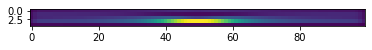

Variance:


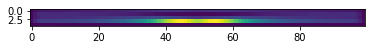

This shows that almost all of the "action" is in a very specific region of one histone modification.


In [8]:
# Per Cell
print('Mean:')
mean_input = plt.imshow(np.mean(np_ins, axis=0))
plt.show()
print('Variance:')
variance_input = plt.imshow(np.std(np_ins, axis=0)**2)
plt.show()
print('This shows that almost all of the "action" is in a very specific region of one histone modification.')

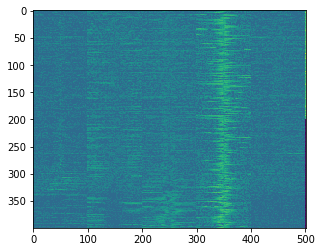

In [9]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([ins.cpu().numpy().reshape(-1, 500)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([ins.cpu().numpy().reshape(-1, 500)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

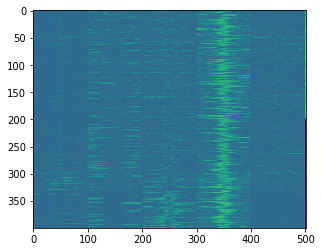

Note how similar the most positive and most negative examples are.


In [10]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([np_ins.reshape(-1, 500)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([np_ins.reshape(-1, 500)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

print('Note how similar the most positive and most negative examples are.')

In [11]:
nph_ins = np.concatenate([np_ins[:, :3], np_ins[:, 4:]], axis=1)
print(nph_ins.shape)

print('If we take out the dominant histone we get the following:')

(720000, 4, 100)
If we take out the dominant histone we get the following:


Input Mean: 0.466
Input Variance: 0.808


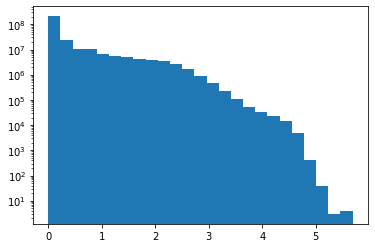

In [12]:
# Overall
print('Input Mean: %.3f' % torch.mean(inputs))
print('Input Variance: %.3f' % torch.std(inputs)**2)
inputs_histogram = plt.hist(nph_ins.reshape(-1), 25, log=True)

Mean:


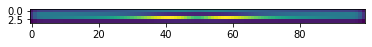

Variance:


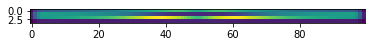

In [13]:
# Per Cell
print('Mean:')
mean_input = plt.imshow(np.mean(nph_ins, axis=0))
plt.show()
print('Variance:')
variance_input = plt.imshow(np.std(nph_ins, axis=0)**2)
plt.show()

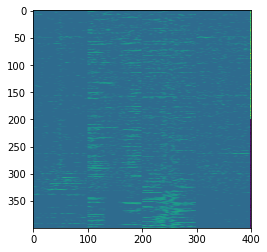

In [14]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([nph_ins.reshape(-1, 400)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([nph_ins.reshape(-1, 400)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

In [15]:
# Per Cell Type
num_cells = 48
cell_samples = inputs.size(0) // num_cells
cells = [(np_ins[i*cell_samples:(i+1)*cell_samples], np_outs[i*cell_samples:(i+1)*cell_samples]) for i in range(num_cells)]
print(cells[-1][0].shape)
print(cells[-1][1].shape)

(15000, 5, 100)
(15000,)


Output distribution for cell 1


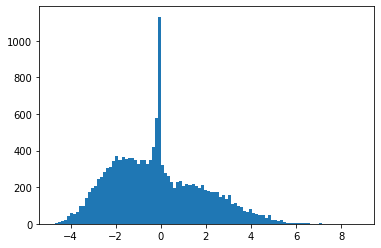

Output distribution for cell 2


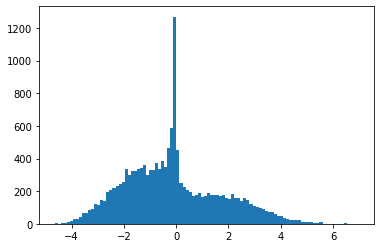

Output distribution for cell 3


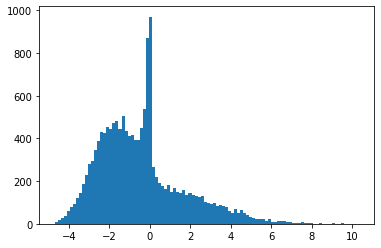

Output distribution for cell 4


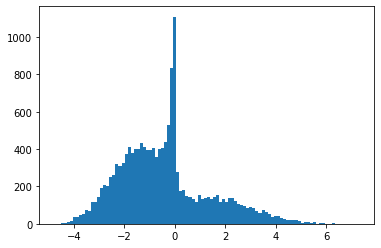

Output distribution for cell 5


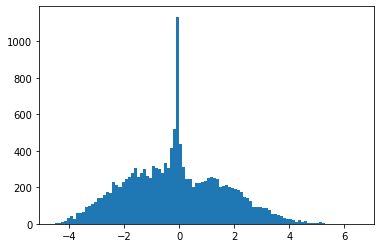

Output distribution for cell 6


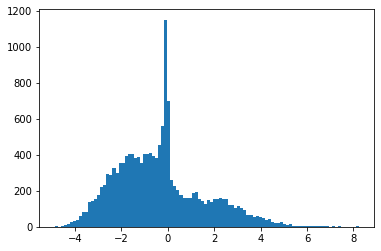

Output distribution for cell 7


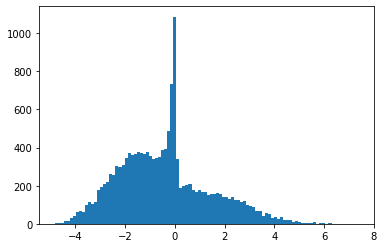

Output distribution for cell 8


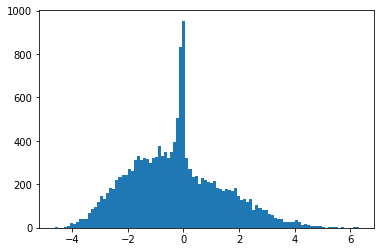

Output distribution for cell 9


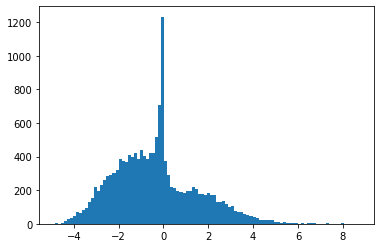

Output distribution for cell 10


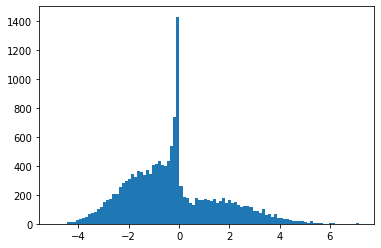

Output distribution for cell 11


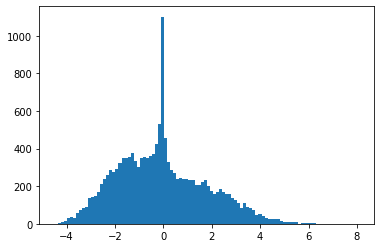

Output distribution for cell 12


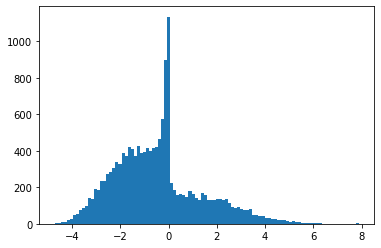

Output distribution for cell 13


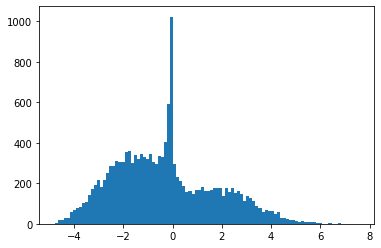

Output distribution for cell 14


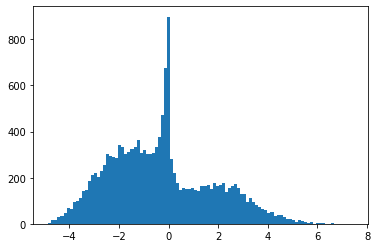

Output distribution for cell 15


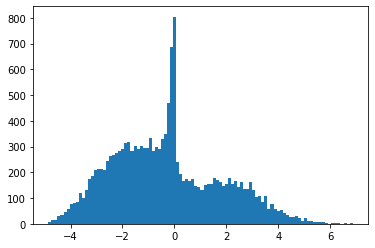

Output distribution for cell 16


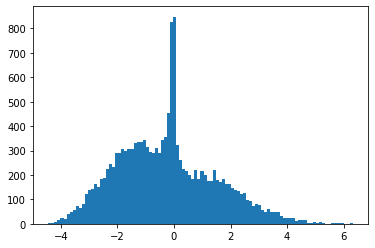

Output distribution for cell 17


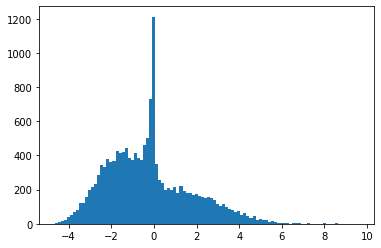

Output distribution for cell 18


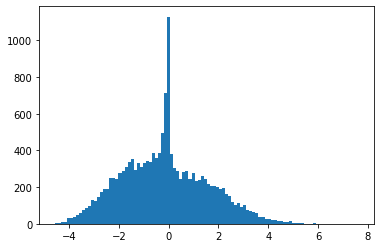

Output distribution for cell 19


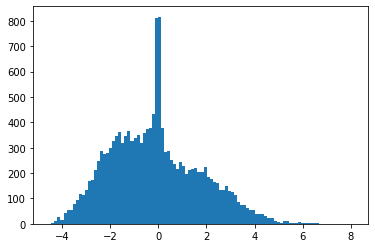

Output distribution for cell 20


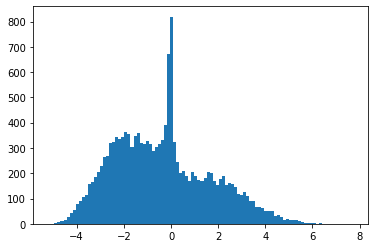

Output distribution for cell 21


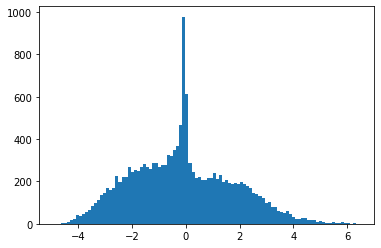

Output distribution for cell 22


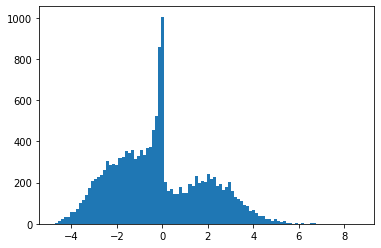

Output distribution for cell 23


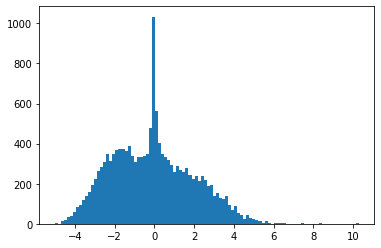

Output distribution for cell 24


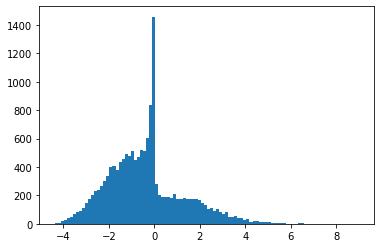

Output distribution for cell 25


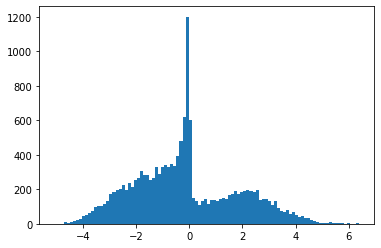

Output distribution for cell 26


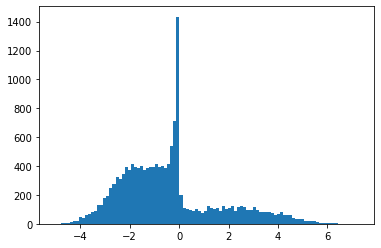

Output distribution for cell 27


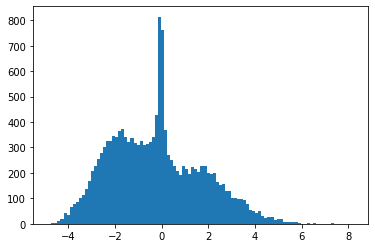

Output distribution for cell 28


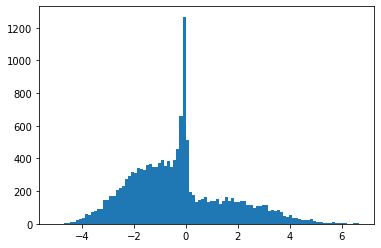

Output distribution for cell 29


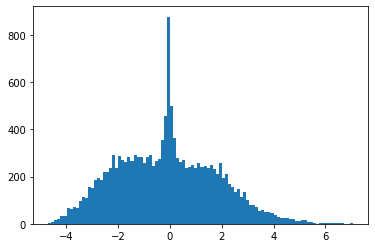

Output distribution for cell 30


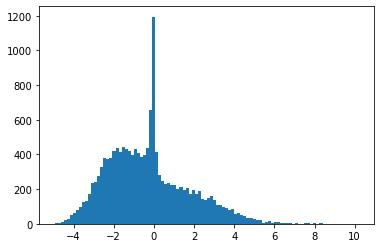

Output distribution for cell 31


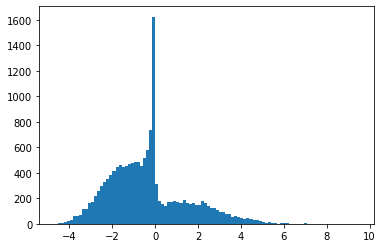

Output distribution for cell 32


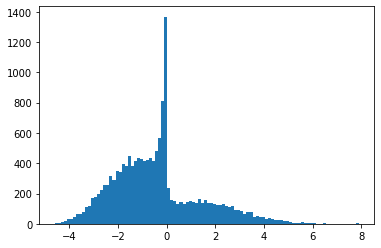

Output distribution for cell 33


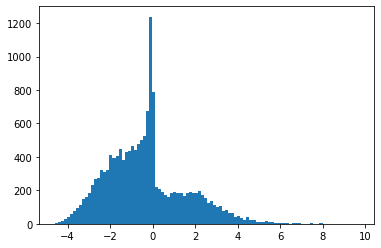

Output distribution for cell 34


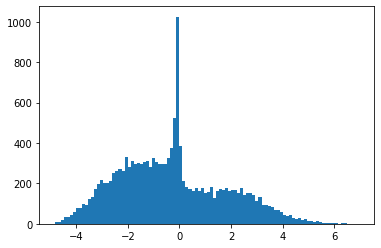

Output distribution for cell 35


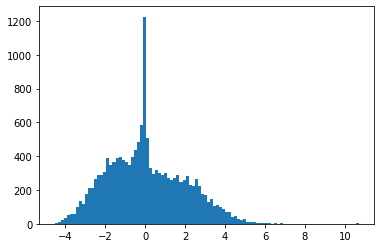

Output distribution for cell 36


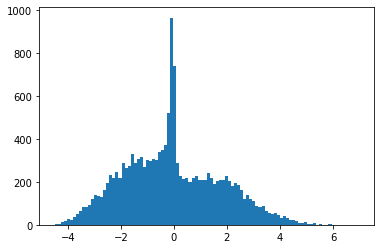

Output distribution for cell 37


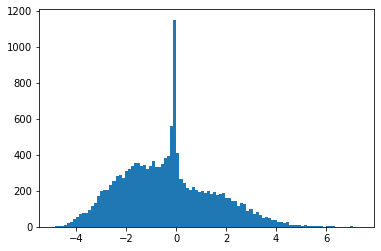

Output distribution for cell 38


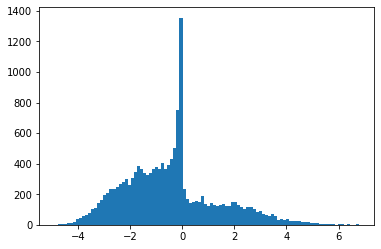

Output distribution for cell 39


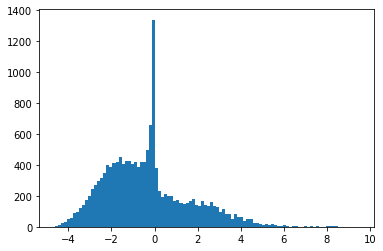

Output distribution for cell 40


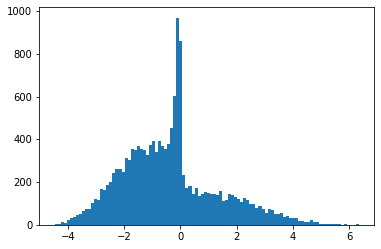

Output distribution for cell 41


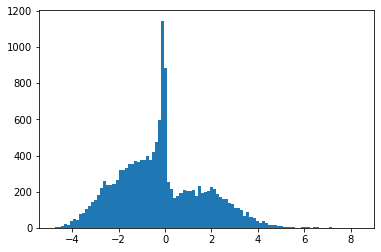

Output distribution for cell 42


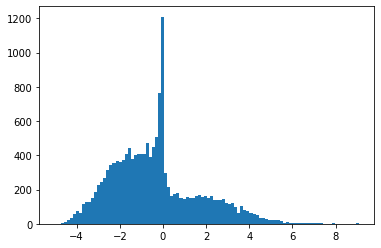

Output distribution for cell 43


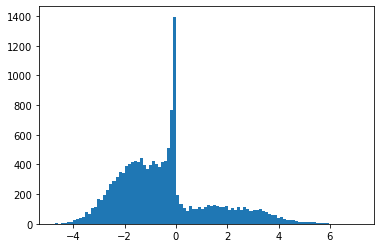

Output distribution for cell 44


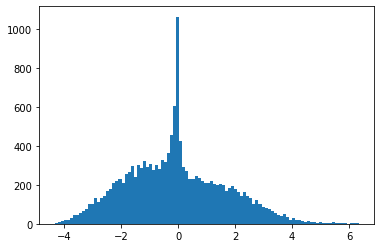

Output distribution for cell 45


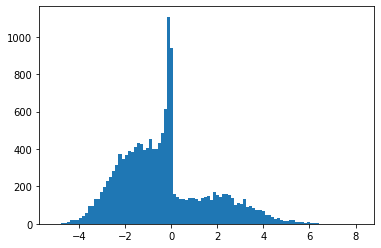

Output distribution for cell 46


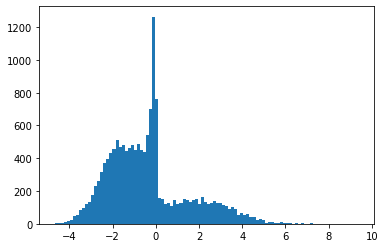

Output distribution for cell 47


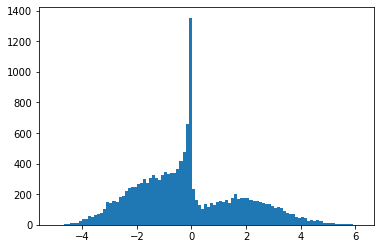

Output distribution for cell 48


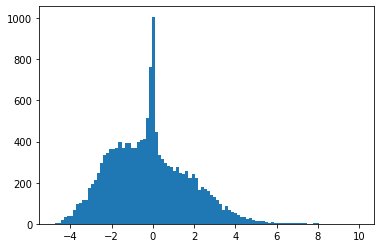

In [16]:
for i in range(num_cells):
    print('Output distribution for cell %d' % (i+1))
    plt.hist(cells[i][1], 100)
    plt.show()

Input distribution for cell 1


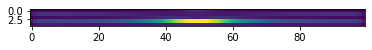

Input distribution for cell 2


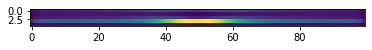

Input distribution for cell 3


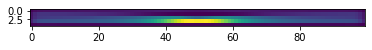

Input distribution for cell 4


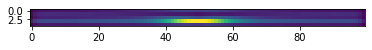

Input distribution for cell 5


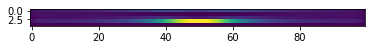

Input distribution for cell 6


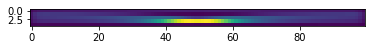

Input distribution for cell 7


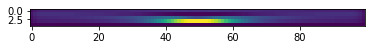

Input distribution for cell 8


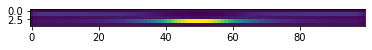

Input distribution for cell 9


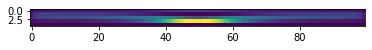

Input distribution for cell 10


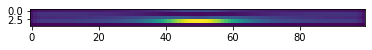

Input distribution for cell 11


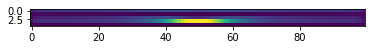

Input distribution for cell 12


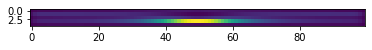

Input distribution for cell 13


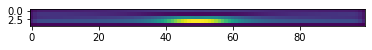

Input distribution for cell 14


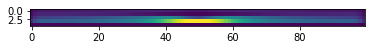

Input distribution for cell 15


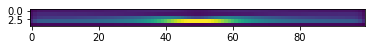

Input distribution for cell 16


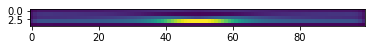

Input distribution for cell 17


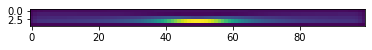

Input distribution for cell 18


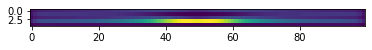

Input distribution for cell 19


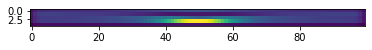

Input distribution for cell 20


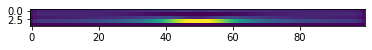

Input distribution for cell 21


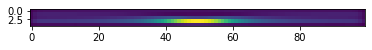

Input distribution for cell 22


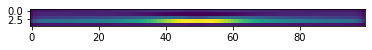

Input distribution for cell 23


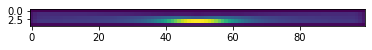

Input distribution for cell 24


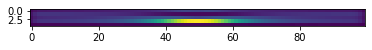

Input distribution for cell 25


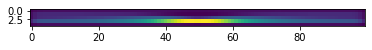

Input distribution for cell 26


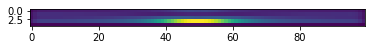

Input distribution for cell 27


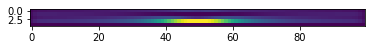

Input distribution for cell 28


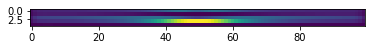

Input distribution for cell 29


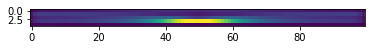

Input distribution for cell 30


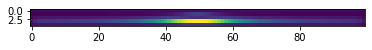

Input distribution for cell 31


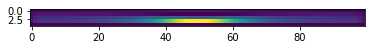

Input distribution for cell 32


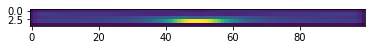

Input distribution for cell 33


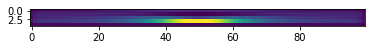

Input distribution for cell 34


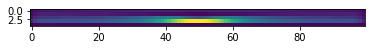

Input distribution for cell 35


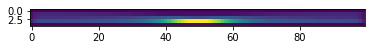

Input distribution for cell 36


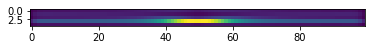

Input distribution for cell 37


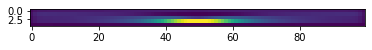

Input distribution for cell 38


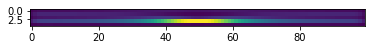

Input distribution for cell 39


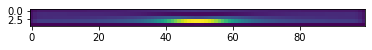

Input distribution for cell 40


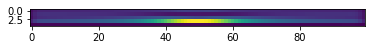

Input distribution for cell 41


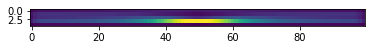

Input distribution for cell 42


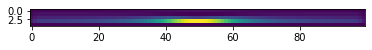

Input distribution for cell 43


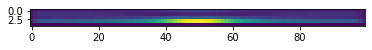

Input distribution for cell 44


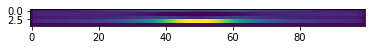

Input distribution for cell 45


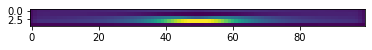

Input distribution for cell 46


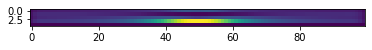

Input distribution for cell 47


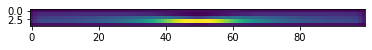

Input distribution for cell 48


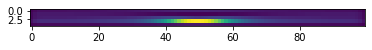

In [17]:
for i in range(num_cells):
    print('Input distribution for cell %d' % (i+1))
    plt.imshow(cells[i][0].mean(axis=0))
    plt.show()

Input distribution for positive cell 1


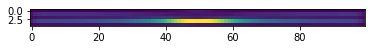

Input distribution for positive cell 2


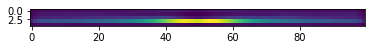

Input distribution for positive cell 3


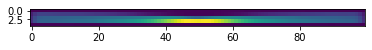

Input distribution for positive cell 4


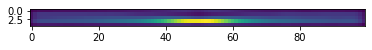

Input distribution for positive cell 5


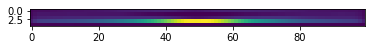

Input distribution for positive cell 6


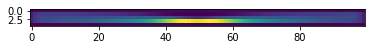

Input distribution for positive cell 7


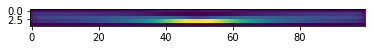

Input distribution for positive cell 8


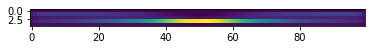

Input distribution for positive cell 9


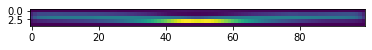

Input distribution for positive cell 10


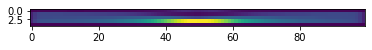

Input distribution for positive cell 11


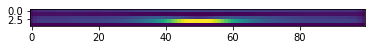

Input distribution for positive cell 12


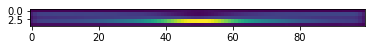

Input distribution for positive cell 13


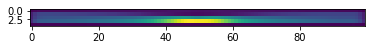

Input distribution for positive cell 14


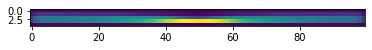

Input distribution for positive cell 15


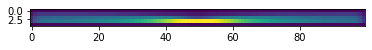

Input distribution for positive cell 16


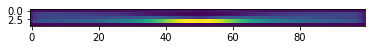

Input distribution for positive cell 17


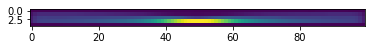

Input distribution for positive cell 18


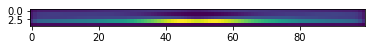

Input distribution for positive cell 19


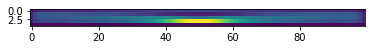

Input distribution for positive cell 20


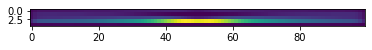

Input distribution for positive cell 21


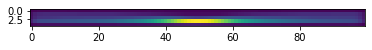

Input distribution for positive cell 22


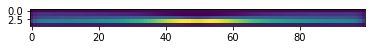

Input distribution for positive cell 23


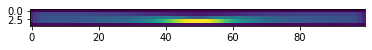

Input distribution for positive cell 24


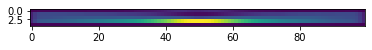

Input distribution for positive cell 25


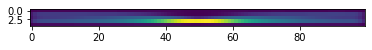

Input distribution for positive cell 26


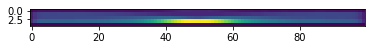

Input distribution for positive cell 27


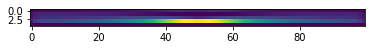

Input distribution for positive cell 28


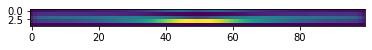

Input distribution for positive cell 29


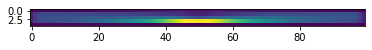

Input distribution for positive cell 30


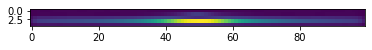

Input distribution for positive cell 31


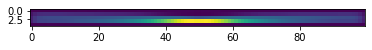

Input distribution for positive cell 32


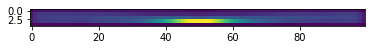

Input distribution for positive cell 33


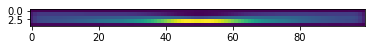

Input distribution for positive cell 34


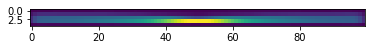

Input distribution for positive cell 35


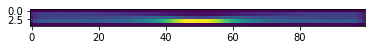

Input distribution for positive cell 36


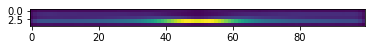

Input distribution for positive cell 37


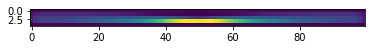

Input distribution for positive cell 38


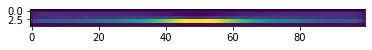

Input distribution for positive cell 39


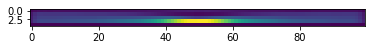

Input distribution for positive cell 40


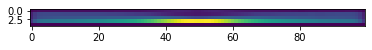

Input distribution for positive cell 41


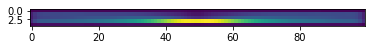

Input distribution for positive cell 42


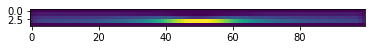

Input distribution for positive cell 43


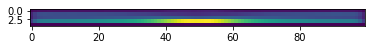

Input distribution for positive cell 44


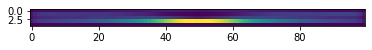

Input distribution for positive cell 45


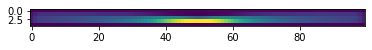

Input distribution for positive cell 46


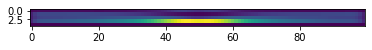

Input distribution for positive cell 47


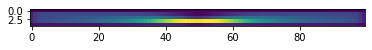

Input distribution for positive cell 48


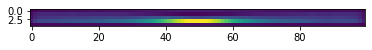

In [18]:
for i in range(num_cells):
    print('Input distribution for positive cell %d' % (i+1))
    plt.imshow(cells[i][0][cells[i][1] > 3].mean(axis=0))
    plt.show()

Input distribution for negative cell 1


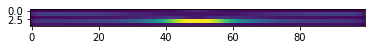

Input distribution for negative cell 2


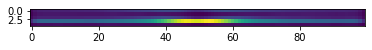

Input distribution for negative cell 3


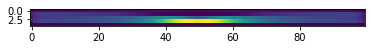

Input distribution for negative cell 4


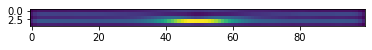

Input distribution for negative cell 5


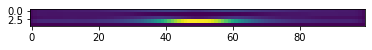

Input distribution for negative cell 6


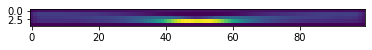

Input distribution for negative cell 7


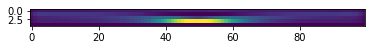

Input distribution for negative cell 8


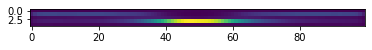

Input distribution for negative cell 9


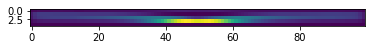

Input distribution for negative cell 10


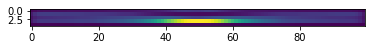

Input distribution for negative cell 11


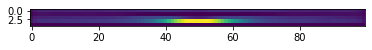

Input distribution for negative cell 12


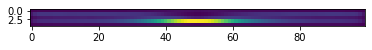

Input distribution for negative cell 13


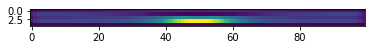

Input distribution for negative cell 14


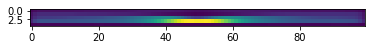

Input distribution for negative cell 15


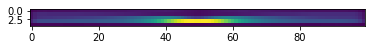

Input distribution for negative cell 16


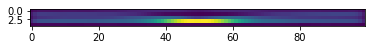

Input distribution for negative cell 17


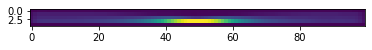

Input distribution for negative cell 18


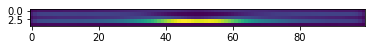

Input distribution for negative cell 19


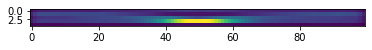

Input distribution for negative cell 20


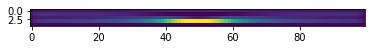

Input distribution for negative cell 21


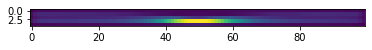

Input distribution for negative cell 22


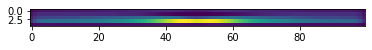

Input distribution for negative cell 23


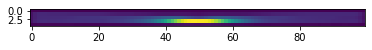

Input distribution for negative cell 24


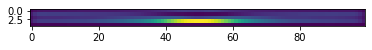

Input distribution for negative cell 25


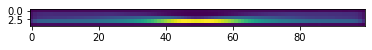

Input distribution for negative cell 26


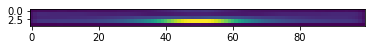

Input distribution for negative cell 27


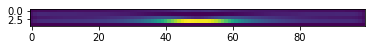

Input distribution for negative cell 28


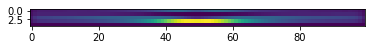

Input distribution for negative cell 29


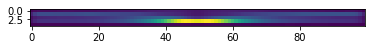

Input distribution for negative cell 30


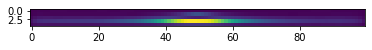

Input distribution for negative cell 31


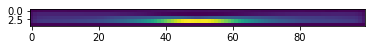

Input distribution for negative cell 32


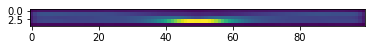

Input distribution for negative cell 33


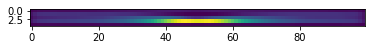

Input distribution for negative cell 34


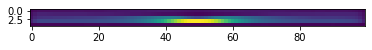

Input distribution for negative cell 35


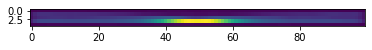

Input distribution for negative cell 36


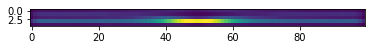

Input distribution for negative cell 37


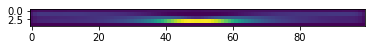

Input distribution for negative cell 38


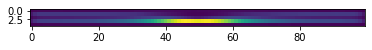

Input distribution for negative cell 39


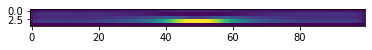

Input distribution for negative cell 40


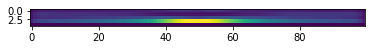

Input distribution for negative cell 41


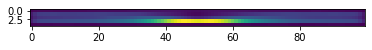

Input distribution for negative cell 42


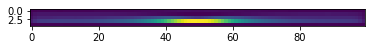

Input distribution for negative cell 43


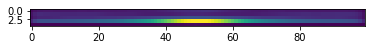

Input distribution for negative cell 44


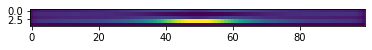

Input distribution for negative cell 45


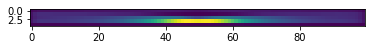

Input distribution for negative cell 46


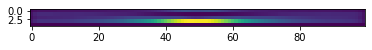

Input distribution for negative cell 47


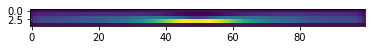

Input distribution for negative cell 48


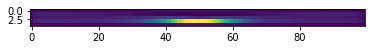

In [19]:
for i in range(num_cells):
    print('Input distribution for negative cell %d' % (i+1))
    plt.imshow(cells[i][0][cells[i][1] < -3].mean(axis=0))
    plt.show()

Input distribution for dif cell 1


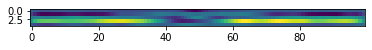

Input distribution for dif cell 2


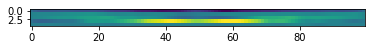

Input distribution for dif cell 3


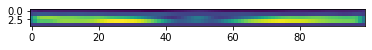

Input distribution for dif cell 4


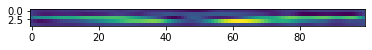

Input distribution for dif cell 5


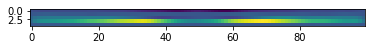

Input distribution for dif cell 6


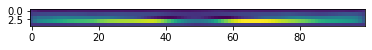

Input distribution for dif cell 7


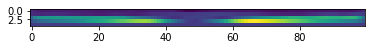

Input distribution for dif cell 8


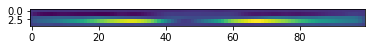

Input distribution for dif cell 9


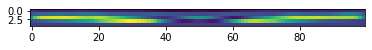

Input distribution for dif cell 10


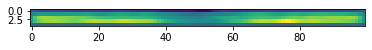

Input distribution for dif cell 11


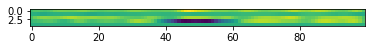

Input distribution for dif cell 12


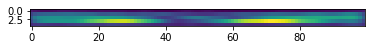

Input distribution for dif cell 13


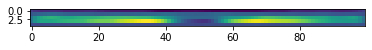

Input distribution for dif cell 14


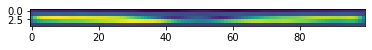

Input distribution for dif cell 15


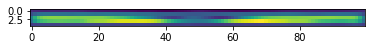

Input distribution for dif cell 16


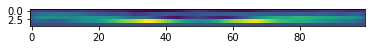

Input distribution for dif cell 17


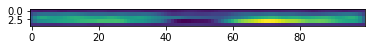

Input distribution for dif cell 18


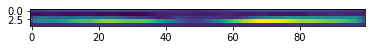

Input distribution for dif cell 19


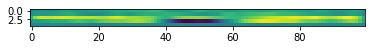

Input distribution for dif cell 20


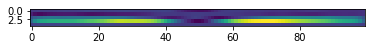

Input distribution for dif cell 21


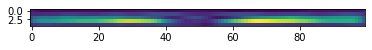

Input distribution for dif cell 22


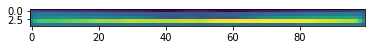

Input distribution for dif cell 23


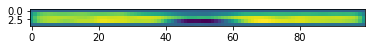

Input distribution for dif cell 24


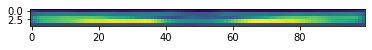

Input distribution for dif cell 25


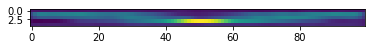

Input distribution for dif cell 26


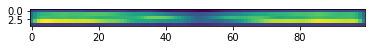

Input distribution for dif cell 27


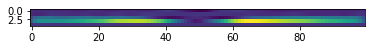

Input distribution for dif cell 28


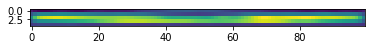

Input distribution for dif cell 29


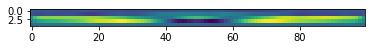

Input distribution for dif cell 30


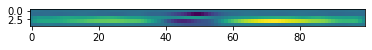

Input distribution for dif cell 31


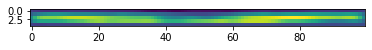

Input distribution for dif cell 32


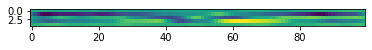

Input distribution for dif cell 33


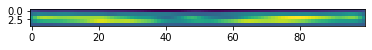

Input distribution for dif cell 34


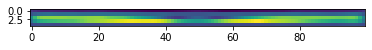

Input distribution for dif cell 35


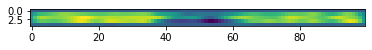

Input distribution for dif cell 36


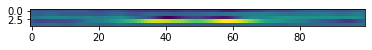

Input distribution for dif cell 37


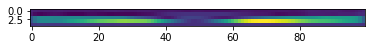

Input distribution for dif cell 38


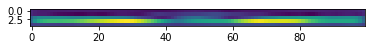

Input distribution for dif cell 39


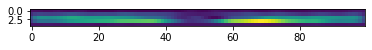

Input distribution for dif cell 40


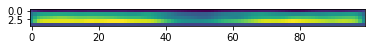

Input distribution for dif cell 41


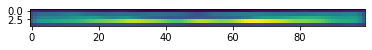

Input distribution for dif cell 42


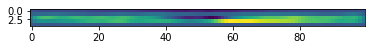

Input distribution for dif cell 43


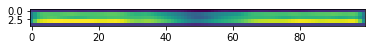

Input distribution for dif cell 44


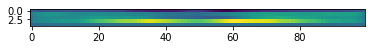

Input distribution for dif cell 45


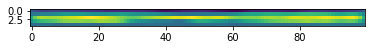

Input distribution for dif cell 46


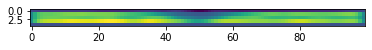

Input distribution for dif cell 47


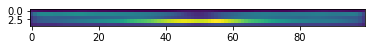

Input distribution for dif cell 48


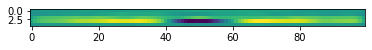

In [20]:
for i in range(num_cells):
    print('Input distribution for dif cell %d' % (i+1))
    plt.imshow(cells[i][0][cells[i][1] > 3].mean(axis=0) - cells[i][0][cells[i][1] < -3].mean(axis=0))
    plt.show()

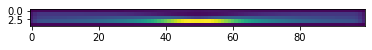

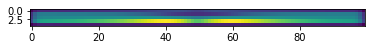

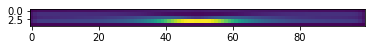

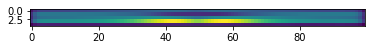

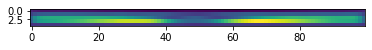

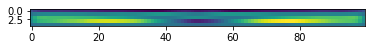

In [21]:
plt.imshow(np_ins[np_outs > 3].mean(axis=0))
plt.show()

plt.imshow(np_ins[np_outs > 3].std(axis=0))
plt.show()

plt.imshow(np_ins[np_outs < -3].mean(axis=0))
plt.show()

plt.imshow(np_ins[np_outs < -3].std(axis=0))
plt.show()

plt.imshow(np_ins[np_outs > 3].mean(axis=0) - np_ins[np_outs < -3].mean(axis=0))
plt.show()

plt.imshow(np_ins[np_outs > 3].std(axis=0) - np_ins[np_outs < -3].std(axis=0))
plt.show()

In [22]:
# How to resample away those peaks??

What if we just resample the dataset according to the square root of the magnitude of the targets?
Output Mean: -0.284
Output Variance: 5.073
Eh, not that much better, although it is something.


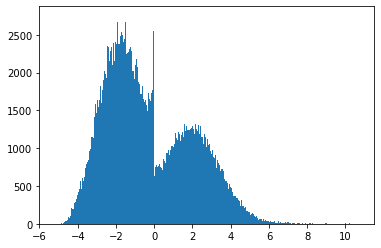

In [23]:
print('What if we just resample the dataset according to the square root of the magnitude of the targets?')

i_outs = torch.multinomial(torch.abs(outputs)**(1/2.5), outputs.size(0), replacement=True)
newouts = outputs[i_outs]

print('Output Mean: %.3f' % torch.mean(newouts))
print('Output Variance: %.3f' % torch.std(newouts)**2)
outputs_histogram = plt.hist(newouts, 1000)

print('Eh, not that much better, although it is something.')

Let's say we want to resample our data to be approximately normal:
Output Mean: -0.000
Output Variance: 3.553


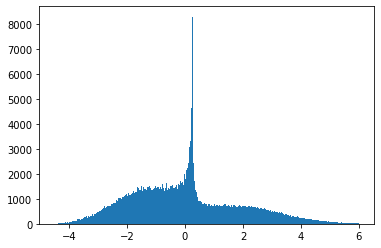

Output Mean: -0.001
Output Variance: 2.246


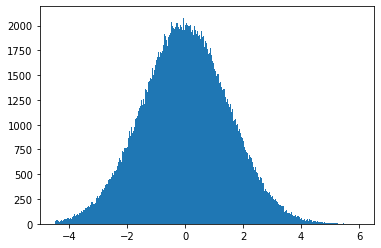

In [24]:
print("Let's say we want to resample our data to be approximately normal:")

centered_outputs = outputs - torch.mean(outputs)
normal_ = torch.randn(outputs.size(0))*1.5
#i_outs = torch.multinomial(outputs, outputs.size(0), replacement=True)
#newouts = outputs[i_outs]

print('Output Mean: %.3f' % torch.mean(centered_outputs))
print('Output Variance: %.3f' % torch.std(centered_outputs)**2)
outputs_histogram = plt.hist(centered_outputs, 1000, (-4.5, 6))
plt.show()

print('Output Mean: %.3f' % torch.mean(normal_))
print('Output Variance: %.3f' % torch.std(normal_)**2)
normal_histogram = plt.hist(normal_, 1000, (-4.5, 6))
plt.show()

To resample to normal we need the transformation distribution between our sample distribution and the normal distribution:


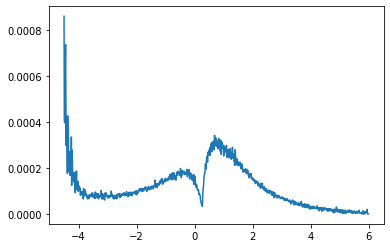

0.00120416662549849


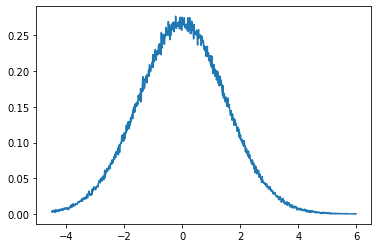

1.0


In [25]:
print('To resample to normal we need the transformation distribution between our sample distribution and the normal distribution:')

# normal = adjust x sample
# adjust = normal / sample
new_histogram = normal_histogram[0] / (outputs_histogram[0] + 1e-6)
new_histogram = new_histogram / (np.sum(new_histogram * outputs_histogram[0]) * 0.0105)
plt.plot(normal_histogram[1][:-1], new_histogram)
plt.show()
print(np.sum(new_histogram) * 0.0105)

reconstruction = new_histogram * outputs_histogram[0]
plt.plot(normal_histogram[1][:-1], reconstruction)
plt.show()
print(np.sum(reconstruction) * 0.0105)

To actually perform the resampling, we need to create a pdf over the indices of our dataset such that when sampled it is approximately normal as above:


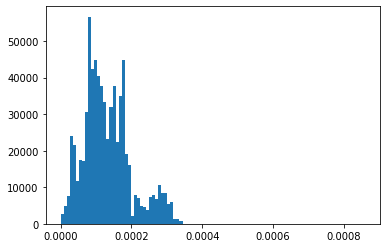

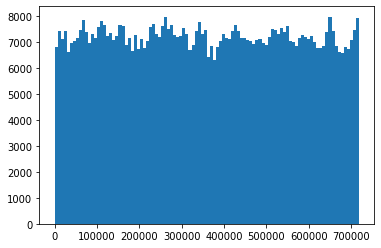

Output Mean: 0.006
Output Variance: 2.216


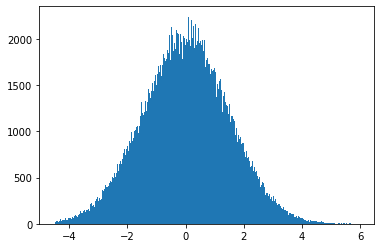

In [26]:
print('To actually perform the resampling, we need to create a pdf over the indices of our dataset such that when sampled it is approximately normal as above:')

# How to use the new histogram to sample from the sample distribution?
# have to line up the outputs for sampling?
logits = centered_outputs
log_ins = inputs
log_ins = log_ins[logits > -4.5]
logits = logits[logits > -4.5]
log_ins = log_ins[logits < 6]
logits = logits[logits < 6]
logits2 = copy.deepcopy(logits)
for idx, edges in enumerate(np.stack([normal_histogram[1][:-1], normal_histogram[1][1:]], axis=1)):
    logits2[(logits >= edges[0]) * (logits <= edges[1])] = new_histogram[idx]

plt.hist(logits2, 100)
plt.show()

'''
Idea:
sort logits, rescale i_outs to be 0 to logits.shape[0] rather than 0 to 1000, and maybe add a little noise
'''

i_outs = torch.multinomial(logits2, outputs.size(0), replacement=True)
plt.hist(i_outs, 100)
plt.show()
#resampled = torch.cat([logits[logits2 == i_out][0:1] for i_out in i_outs])
#i_outs = (i_outs * multiplier + torch.rand(i_outs.shape)*multiplier).long()
resampled = logits[i_outs]
resampled_inputs = log_ins[i_outs]


print('Output Mean: %.3f' % torch.mean(resampled.float()))
print('Output Variance: %.3f' % torch.std(resampled.float())**2)
outputs_histogram = plt.hist(resampled.numpy(), 1000)

In [27]:
print('Save that resampled data!')

torch.save(resampled, 'resampled_out.pt')
torch.save(resampled_inputs, 'resampled_in.pt')

Save that resampled data!


In [28]:
kmean_ins = np.concatenate([np_ins.reshape(-1, 500), np.zeros(np_ins.shape[0], 1)], axis=1)
for i in range(48):
    kmean_ins[i*15000:(i+1)*15000, -1] = i*100
kmeans = KMeans(n_clusters=48, n_jobs=-1).fit(kmean_ins)

TypeError: data type not understood

In [ ]:
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))

In [ ]:
kmean_ins = np.concatenate([np_ins.reshape(-1, 500), np.zeros((np_ins.shape[0], 1))], axis=1)
predictions = kmeans.predict(kmean_ins)
scores = [kmeans.transform(np.concatenate([np_ins.reshape(-1, 500), i*100*np.ones((np_ins.shape[0], 1))], axis=1)) for i in range(48)]

In [ ]:
plt.hist(predictions)
plt.show()

In [ ]:
plt.scatter(scores[:,0], scores[:,1])
plt.show()
plt.scatter(scores[:,1], scores[:,2])
plt.show()
plt.scatter(scores[:,2], scores[:,3])
plt.show()
plt.scatter(scores[:,35], scores[:,25])
plt.show()

In [ ]:
ensemble_logits = torch.from_numpy(scores)
ensemble_weights = torch.nn.functional.softmax(-1*ensemble_logits, dim=1)

In [ ]:
plt.scatter(ensemble_weights[:,35], ensemble_weights[:,25])
plt.show()
ensemble_predictions = torch.randn(ensemble_weights.size())
ensemble_weighted_predict = torch.sum(ensemble_weights * ensemble_predictions, dim=1)
print(ensemble_weighted_predict)
print(torch.mean(ensemble_weighted_predict))
print(torch.std(ensemble_weighted_predict))